In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
train=pd.read_csv('train_Wc8LBpr.csv')
test=pd.read_csv('test_VsU9xXK.csv')
sample=pd.read_csv('sample_submission_NoPBkjr.csv')

In [4]:
print("train dataset is of shape: ", train.shape)
print("test dataset is of shape: ", test.shape)
print("sample dataset is of shape: ", sample.shape)

train dataset is of shape:  (131662, 14)
test dataset is of shape:  (87395, 13)
sample dataset is of shape:  (87395, 2)


In [5]:
train.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [6]:
train.select_dtypes(include='object').apply(lambda x: (len(x.unique()))) 

Trip_ID                        131662
Type_of_Cab                         6
Confidence_Life_Style_Index         4
Destination_Type                   14
Gender                              2
dtype: int64

In [7]:
test.select_dtypes(include='object').apply(lambda x: (len(x.unique()))) 

Trip_ID                        87395
Type_of_Cab                        6
Confidence_Life_Style_Index        4
Destination_Type                  14
Gender                             2
dtype: int64

##### It;s evidence that there is no difference in the data of categories in trian and test dataset

In [8]:
d1=train.isnull().sum().to_frame().rename(columns={0: "Train_Null_Values"})
d2=test.isnull().sum().to_frame().rename(columns={0: "Test_Null_Values"})
d3=train.dtypes.to_frame().rename(columns={0: "Data_Type"})
pd.concat([d1, d2,d3], axis=1)

,Train_Null_Values,Test_Null_Values,Data_Type
Trip_ID,0,0.0,object
Trip_Distance,0,0.0,float64
Type_of_Cab,20210,13158.0,object
Customer_Since_Months,5920,3966.0,float64
Life_Style_Index,20193,13327.0,float64
Confidence_Life_Style_Index,20193,13327.0,object
Destination_Type,0,0.0,object
Customer_Rating,0,0.0,float64
Cancellation_Last_1Month,0,0.0,int64
Var1,71030,46789.0,float64


#### EDA

##### Target Exploration

In [9]:
train['Surge_Pricing_Type'].value_counts()

2    56728
3    47720
1    27214
Name: Surge_Pricing_Type, dtype: int64

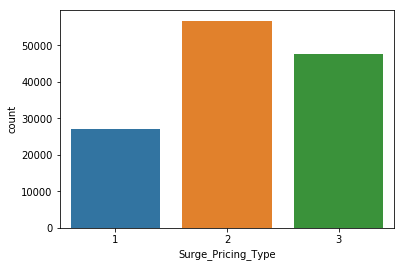

In [10]:
sns.countplot(train["Surge_Pricing_Type"])

##### Univariate Analysis

In [11]:
combine = train.append(test,sort=False)
print("combine dataset is of shape: ", combine.shape)

combine dataset is of shape:  (219057, 14)


In [12]:
cat_col = combine.dtypes.loc[combine.dtypes!='object'].index
cat_col

Index(['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3',
       'Surge_Pricing_Type'],
      dtype='object')

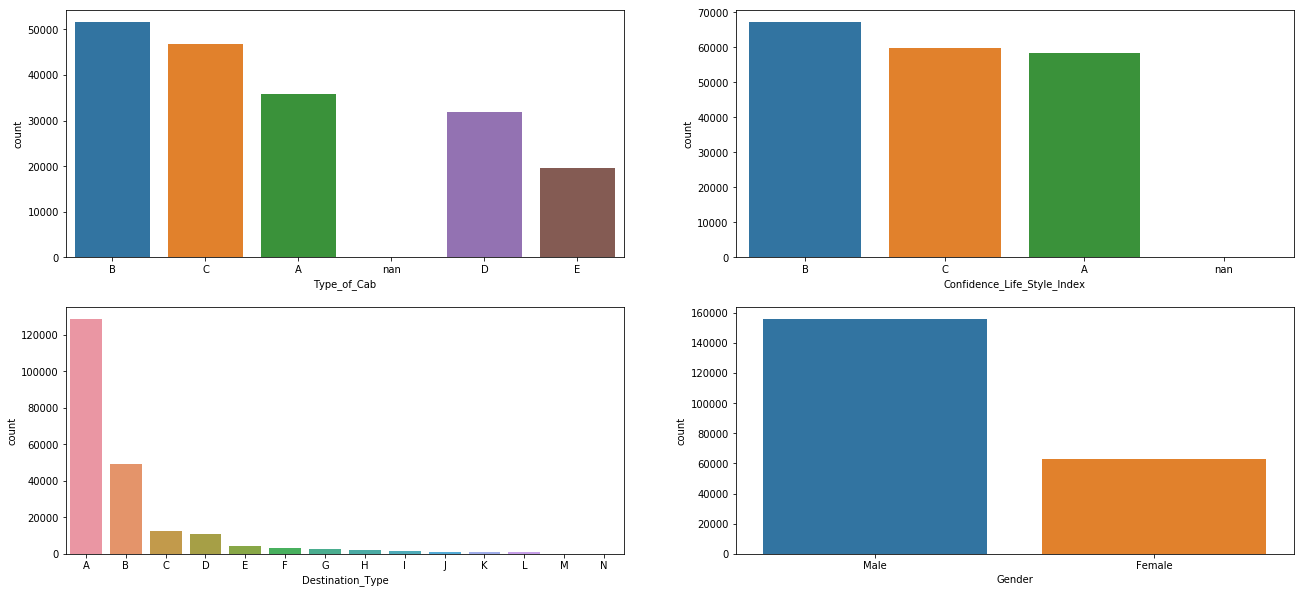

In [13]:
plt.figure(figsize=(22, 10))
plt.subplot(221)
sns.countplot(combine['Type_of_Cab'],order = combine['Type_of_Cab'].value_counts(dropna=False).index)
plt.subplot(222)
sns.countplot(combine['Confidence_Life_Style_Index'],order = combine['Confidence_Life_Style_Index'].value_counts(dropna=False).index)
plt.subplot(223)
sns.countplot(combine['Destination_Type'],order = combine['Destination_Type'].value_counts(dropna=False).index)
plt.subplot(224)
sns.countplot(combine['Gender'],order = combine['Gender'].value_counts(dropna=False).index)

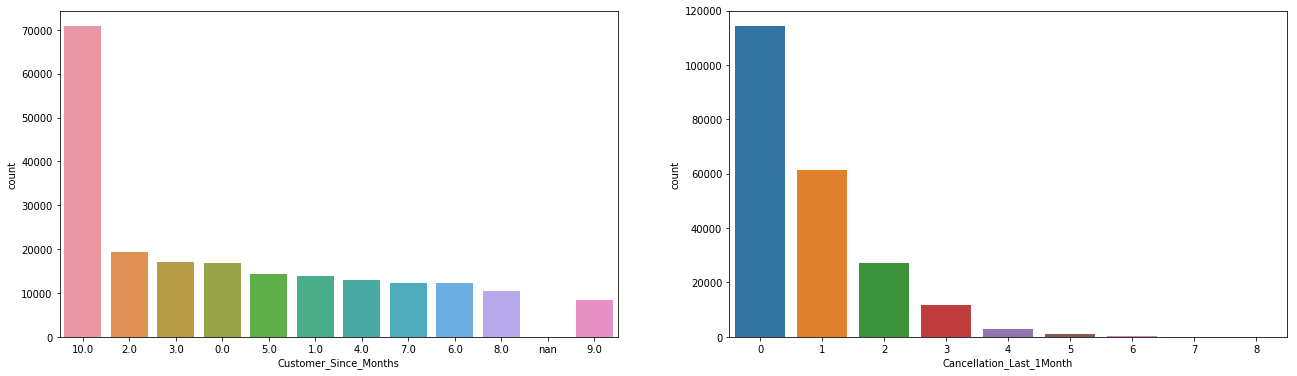

In [14]:
plt.figure(figsize=(22, 6))
plt.subplot(121)
sns.countplot(combine['Customer_Since_Months'],order = combine['Customer_Since_Months'].value_counts(dropna=False).index)
plt.subplot(122)
sns.countplot(combine['Cancellation_Last_1Month'],order = combine['Cancellation_Last_1Month'].value_counts(dropna=False).index)

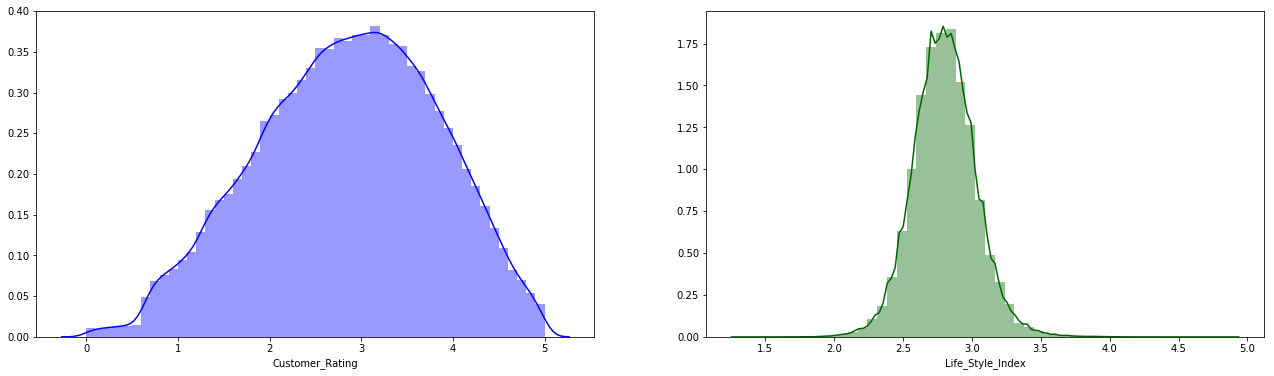

In [15]:
plt.figure(figsize=(22, 6))
plt.subplot(121)
sns.distplot(combine['Customer_Rating'].dropna(),color='blue')
plt.subplot(122)
sns.distplot(combine['Life_Style_Index'].dropna(),color='darkgreen')

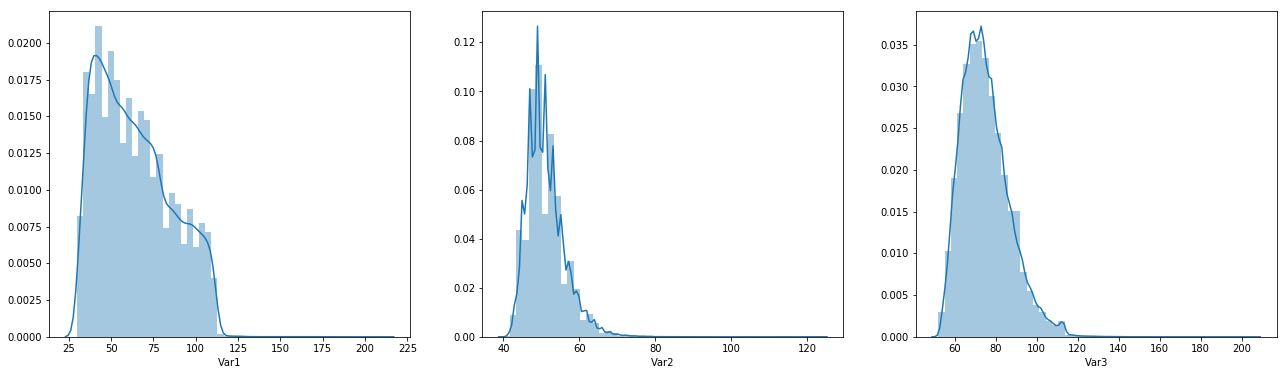

In [16]:
plt.figure(figsize=(22, 6))
plt.subplot(131)
sns.distplot(combine['Var1'].dropna())
plt.subplot(132)
sns.distplot(combine['Var2'])
plt.subplot(133)
sns.distplot(combine['Var3'])

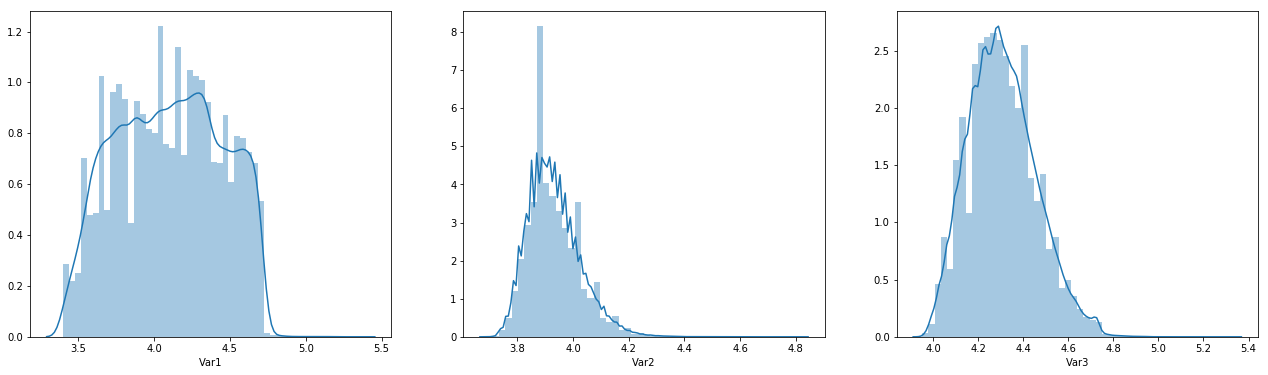

In [17]:
plt.figure(figsize=(22, 6))
plt.subplot(131)
sns.distplot(np.log(combine['Var1'].dropna()))
plt.subplot(132)
sns.distplot(np.log(combine['Var2']))
plt.subplot(133)
sns.distplot(np.log(combine['Var3']))

In [18]:
combine['Var1'].fillna(int(combine['Var1'].mean()), inplace=True)
combine['Var1']=np.log(combine['Var1'])
combine['Var2']=np.log(combine['Var2'])
combine['Var3']=np.log(combine['Var3'])

In [19]:
combine = pd.concat([combine, pd.get_dummies(combine["Type_of_Cab"], prefix="Cab_Type_")], axis=1)

In [20]:
combine.Type_of_Cab.value_counts()

B    51585
C    46732
A    35878
D    31885
E    19609
Name: Type_of_Cab, dtype: int64

In [21]:
combine.drop('Cab_Type__E',1,inplace=True)

In [22]:
combine = pd.concat([combine, pd.get_dummies(combine["Confidence_Life_Style_Index"], prefix="CLSI_")], axis=1)

In [23]:
combine.Confidence_Life_Style_Index.value_counts()

B    67265
C    59736
A    58536
Name: Confidence_Life_Style_Index, dtype: int64

In [24]:
combine.drop('CLSI__A',1,inplace=True)

In [25]:
combine = pd.concat([combine, pd.get_dummies(combine["Destination_Type"], prefix="DT_")], axis=1)
combine.drop('DT__N',1,inplace=True)

In [26]:
combine.Destination_Type.value_counts()

A    129010
B     49193
C     12397
D     11085
E      4549
F      3222
G      2513
H      2124
I      1334
J      1166
K      1102
L      1052
M       160
N       150
Name: Destination_Type, dtype: int64

In [27]:
combine = pd.concat([combine, pd.get_dummies(combine["Gender"], prefix="Gender_")], axis=1)
combine.drop('Gender__Female',1,inplace=True)

In [28]:
combine.Gender.value_counts()

Male      156128
Female     62929
Name: Gender, dtype: int64

In [29]:
combine=combine.drop(["Type_of_Cab", "Confidence_Life_Style_Index", "Destination_Type", "Gender"],axis=1)

In [30]:
train_cleaned = combine[:train.shape[0]]
test_cleaned = combine[train.shape[0]:]

In [31]:
target_map = {1:0, 2:1, 3:2}
target_map_inverse = {0:1, 1:2, 2:3}

In [32]:
train_cleaned["Surge_Pricing_Type"] = train_cleaned["Surge_Pricing_Type"].map(target_map)

C:\Users\SJMB\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
X=train_cleaned.drop(['Surge_Pricing_Type','Trip_ID'],axis=1)
y=train_cleaned['Surge_Pricing_Type']
X_test=test_cleaned.drop(['Surge_Pricing_Type','Trip_ID'],axis=1)

In [34]:
X.shape, y.shape, X_test.shape

((131662, 28), (131662,), (87395, 28))

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [36]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.05,
                       n_estimators=5000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       random_state=1994,
                       objective='multiclass')

model.fit(x_train,y_train,
          eval_set=[(x_train,y_train),(x_val, y_val.values)],
          early_stopping_rounds=100,
          verbose=200)

pred_y = model.predict(x_val)

Training until validation scores don't improve for 100 rounds
[200]	training's multi_logloss: 0.695301	valid_1's multi_logloss: 0.709515
[400]	training's multi_logloss: 0.674483	valid_1's multi_logloss: 0.700874
[600]	training's multi_logloss: 0.66134	valid_1's multi_logloss: 0.699357
Early stopping, best iteration is:
[627]	training's multi_logloss: 0.659771	valid_1's multi_logloss: 0.699249


In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(y_val, pred_y))
confusion_matrix(y_val,pred_y)

0.7019329358599476


array([[3153, 1652,  671],
       [ 564, 8676, 2045],
       [ 456, 2461, 6655]], dtype=int64)

In [38]:
err = []
y_pred_tot_lgm = []
from sklearn.model_selection import StratifiedKFold
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
i = 1
for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    
    y_train, y_val = y[train_index], y[test_index]
    
    m = LGBMClassifier(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.05,
                       n_estimators=5000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       random_state=1994,
                       objective='multiclass')
    
    m.fit(x_train, y_train, eval_set=[(x_train,y_train),(x_val, y_val)],       early_stopping_rounds=200,        verbose=200)
    
    pred_y = m.predict(x_val)
    
    print(i, " err_lgm: ", accuracy_score(y_val, pred_y))
    
    err.append(accuracy_score(y_val, pred_y))
    
    pred_test = m.predict(X_test)
    
    i = i + 1
    
    y_pred_tot_lgm.append(pred_test)

Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.696391	valid_1's multi_logloss: 0.704303
[400]	training's multi_logloss: 0.67563	valid_1's multi_logloss: 0.695711
[600]	training's multi_logloss: 0.663008	valid_1's multi_logloss: 0.694258
[800]	training's multi_logloss: 0.652248	valid_1's multi_logloss: 0.694136
Early stopping, best iteration is:
[761]	training's multi_logloss: 0.654283	valid_1's multi_logloss: 0.693999
1  err_lgm:  0.7041734705502601
Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.694946	valid_1's multi_logloss: 0.710025
[400]	training's multi_logloss: 0.674034	valid_1's multi_logloss: 0.701793
[600]	training's multi_logloss: 0.661127	valid_1's multi_logloss: 0.700594
[800]	training's multi_logloss: 0.650073	valid_1's multi_logloss: 0.700689
Early stopping, best iteration is:
[715]	training's multi_logloss: 0.654638	valid_1's multi_logloss: 0.700533
2  err_lgm:  0.6995405005

In [39]:
np.mean(err, 0)

0.7006197500078152

In [40]:
sample['Surge_Pricing_Type'] = y_pred_tot_lgm[3]
sample['Surge_Pricing_Type']=sample['Surge_Pricing_Type'].map(target_map_inverse)
sample.to_csv('LGBM.csv', index=False)
sample.shape

(87395, 2)